<a href="https://colab.research.google.com/gist/qbeer/1df46c5028ad976dcf497f8117046830/hw9_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural networks, introduction


### 1. Implement a logistic regression model on MNIST for binary classification in Numpy

* use `from sklearn.datasets import load_digits`
  * the provided data files: X_train, X_test are a split generated by the author of this exercise
  * w, b are the fitted logistic regression weight and bias, the predictions on the provided test set can be generated by: `y_pred_test = sigmoid(np.dot(w, X_test.T) + b)`
  * the binarized accuracy score should be above 98% for this particular data
* divide the data into 0 vs. 1-9. categories
  * the goal is to separate the zeros
* y = logistic(wx + b)
* optimize the model via stochastic mini-batch gradient descent until you reach above 90% accuracy on the test set

* the loss:

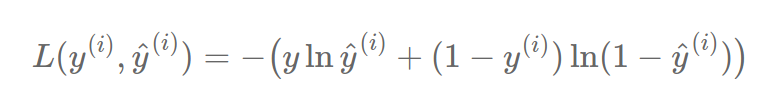

* the gradients of the mini-batch loss:

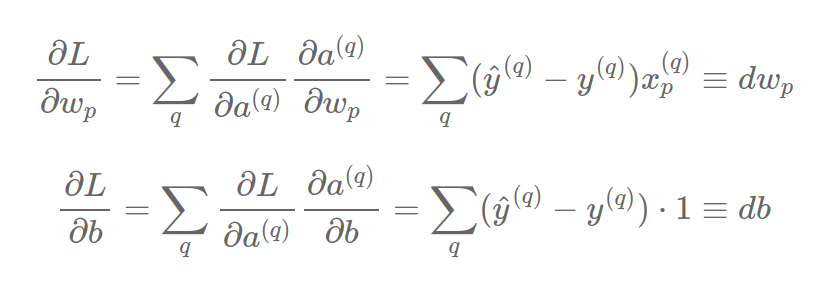



For some reason, this task does not add up in my head, so I had to look at different solutions! Of course, this exact solution is not in them!

1. Is there anything specific about the classification? 

https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py


2. Logistic regression:

https://machinelearningmastery.com/implement-logistic-regression-stochastic-gradient-descent-scratch-python/


3. Loss function and the mini batch gradient:

https://stats.stackexchange.com/questions/266968/how-does-minibatch-gradient-descent-update-the-weights-for-each-example-in-a-bat

In [184]:
import numpy as np
import pandas as pd

import math

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
import os 
import pathlib
import glob

from sklearn.datasets import load_digits
from sklearn import metrics

Forgot that they already provided a dataset for this... That they split before hand... and

In [28]:
X_train = np.load("./data/X_train.npy")
y_train = np.load("./data/y_train.npy")
X_test = np.load("./data/X_test.npy")
y_test = np.load("./data/y_test.npy")

b_init = np.load("./data/b.npy")
w_init = np.load("./data/w.npy")

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(b_init.shape)
print(w_init.shape)

(1618, 64)
(1618, 1)
(179, 64)
(179, 1)
()
(1, 64)


In [38]:
X_train[0]

array([ 0.        , -0.3394476 , -0.04044349,  0.28459854, -0.67387118,
       -0.8461742 , -0.41473844, -0.12495473, -0.04722214, -0.62852742,
        0.48931403,  0.75221779, -0.04861155,  1.14818784,  0.87028995,
       -0.13127165, -0.03337249,  0.11573289,  0.8926328 , -0.87433486,
       -1.14728765,  0.53201184,  1.88789566, -0.11808942, -0.03517987,
        0.48053982,  0.46290925, -1.53725584, -1.62920159,  0.07451696,
        1.51270598, -0.04978267,  0.        ,  0.75417842,  0.04791859,
       -1.461766  , -1.74927733,  0.03331645,  1.46527707,  0.        ,
       -0.06466137,  0.80714535,  0.63337525, -1.12779606, -1.06176828,
        0.65078693,  0.82259266, -0.08729752, -0.03734445,  0.73139557,
        1.15477837, -0.85284642,  0.10193343,  0.53745913, -0.75683605,
       -0.20646752, -0.02486823, -0.30188347,  0.08337664,  0.21711379,
       -0.37199005, -1.14591916, -0.50428416, -0.18504012])

This is the prediction that should be used as the reference. My implementation needs to reach this level of accuracy if not more. THe exercise states that I should reach a 90% accuracy.

In [197]:
y_pred_test = np.around(sigmoid(np.dot(w_init, X_test.T) + b_init))

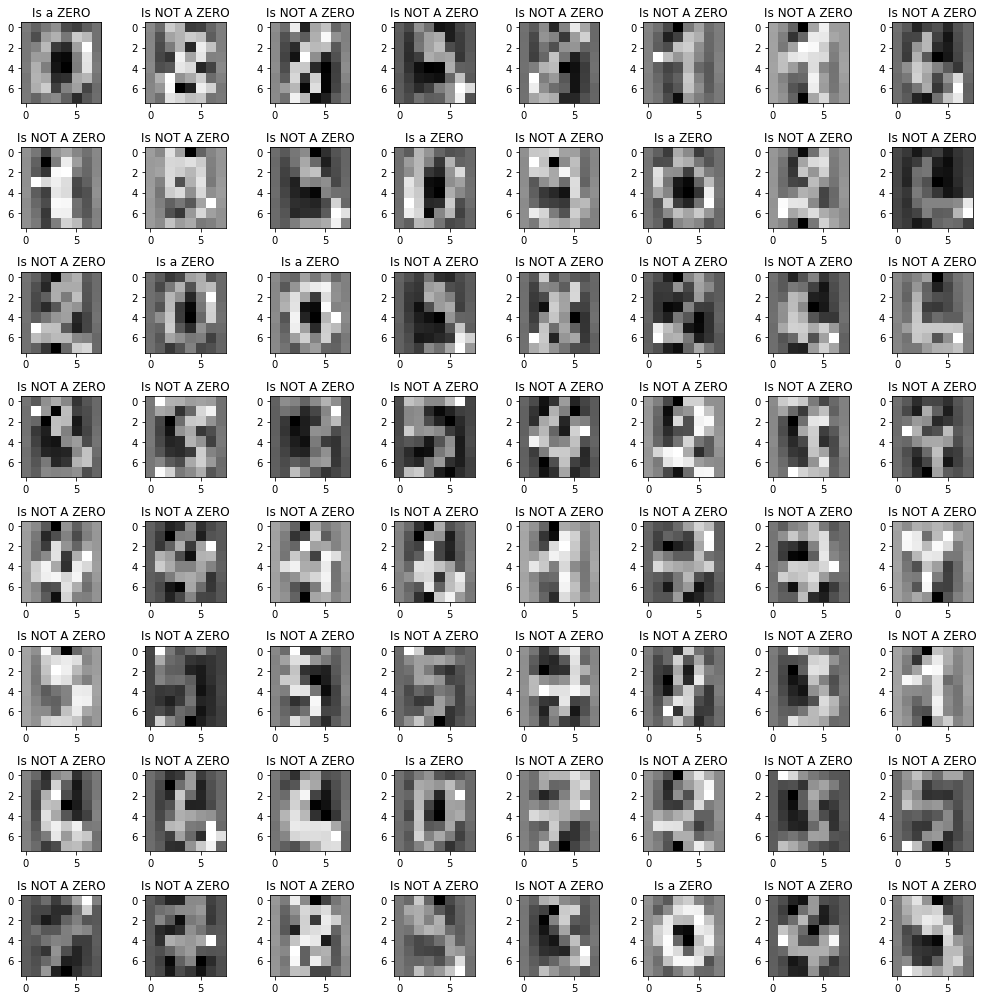

In [42]:
nrows=8
ncols=8

title_nameset = ["Is a ZERO", "Is NOT A ZERO"]

fig, ax = plt.subplots(nrows,ncols,figsize=(14,14))

for i in range(ncols):
    for j in range(nrows):
        image = X_train[i+j*ncols].reshape(8,8)
        ax[i,j].imshow(image, cmap="gray", interpolation="nearest")
        ax[i,j].set_title(title_nameset[int(y_train[i+j*ncols])])

fig.tight_layout()        
plt.show()

Just a couple of NOTEs!

[1] The data is the same as the images, but it is flattened 

[2] I will use the data for prediction

Let's implement a mini-batch gradient descent!

NOTE:

b: bias is a silly name for the intercept_ that is used in sklearn...

In [186]:
def sigmoid(value):
    """
    Returns the values inputted into a sigmoid function
    
    INPUT:
        value: value, FLOAT
    OUTPUT:
        returned value after applying the sigmoid function
    
    """
    return 1.0/(1.0+np.exp(-value))

def predict(X,w0):
    """
    Predicting values
    
    INPUT:
        X: input values for the prediction
        b0: bias
        w0: weights
    OUTPUT:
        y_pred: prediction for logistic regression
    """
    return sigmoid(np.dot(w0, X.T))

def predict2(X,w0,b0):
    """
    Predicting values
    
    INPUT:
        X: input values for the prediction
        b0: bias
        w0: weights
    OUTPUT:
        y_pred: prediction for logistic regression
    """
    return sigmoid(np.dot(w0, X.T)+b0)

def minibatch_gradient_descent(X,y,b,w,learning_rate=0.01,iterations=10, batch_size=20):
    """
    Mini-batch descent with shuffle and (almost) logistic regression burned in.
    
    INPUT:
        X: input values for fitting, ARRAY
        y: target values for logistic regression, ARRAY
        b: bias for logistic regression, FLOAT
        w: weigths for every feature in the dataset
        learning_rate: user given learning rate for the mini_batch
        iterations: number of iterations, INT
        batch_size: size of batch, INT
    OUTPUT
        w: finalized coefs, bias included
        cost_history: cost history for the fit
    
    """
    m = len(y)
    cost_history = np.zeros(iterations)
    n_batches = int(m / batch_size)
    for it in range(iterations):
        cost=0.0
        
        #shuffle
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        
        #NOTE: i have to calculate the loss for every row
        #      and than sum it up to calculate the new coeffs
        
        for i in range(0,m,batch_size):
            #init valaues and containers for the mini-batch
            X_i = X[i:i+batch_size]
            y_i = y[i:i+batch_size]
            #X_i = np.c_[np.ones(len(X_i)), X_i]                                  #the guide doesnt really sa anything about why is this concatenation is needed
            
            #prediction = np.dot(X_i, theta)                                      #this has to be changed for y_pred_test
            prediction = np.vstack(predict2(X_i,w,b))
            #update
            b = b - (1/batch_size) * learning_rate*(np.ones(len(X_i)).dot(prediction - y_i).flatten())
            w = w - (1/batch_size) * learning_rate*(X_i.T.dot((prediction - y_i))).flatten()#bias (b) = w[0], weight (w) = w[1:]
                                                                                   #additional row for all the other coeffs
            #cost += cal_cost(theta,X_i,y_i)                                       #this is not here at all
        #cost_history[it] = cost
    return b, w, cost_history

def confusion_m_plot(y1,y2):
    C_MY = metrics.confusion_matrix(y1, y2)
    display(C_MY)

    fig,ax = plt.subplots(1,1,figsize=(7,7))




    ax.set_xticks(np.arange(0,len(C_MY[0,:])))            #class ticks place
    ax.set_yticks(np.arange(0,len(C_MY[:,0])))            #survived ticks place
    ax_x = ["ZERO", "NOT ZERO"]                           #class tick labels
    ax_y = ["ZERO", "NOT ZERO"]                           #survived tick labels
    ax.set_xticklabels(ax_x, fontsize=18)
    ax.set_yticklabels(ax_y, fontsize=18)


    ax.set_title("SVC's Confusion Matrix", fontsize=20)
    im1 = ax.imshow(C_MY, cmap="gray")

    for i in range(0,len(C_MY)):
        for j in range(0,2):
            color0="black"
            if(int(round(C_MY[i,j])) < int(round(np.max(C_MY)))*0.7):
                color0 = "white"
            text = ax.text(j, i, str(C_MY[i, j]),
                           ha="center", va="center", color=color0, fontsize=21)    

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')        

    fig.tight_layout()

    plt.show()

So, we have many many many nonzero targets, about 1/10... Let's see if this very simple implementation works


In [194]:
bias = 1
w_i = np.ones(64) * 0.01
bias_end, w_end, c_ = minibatch_gradient_descent(X_train,
                                                 y_train,
                                                 b=bias,
                                                 w=w_i,
                                                 learning_rate=0.01,
                                                 iterations=1000,
                                                 batch_size=32)
y_pred0 = np.around(predict2(X_train, w_end, bias_end))
y_pred = np.around(predict2(X_test, w_end, bias_end))

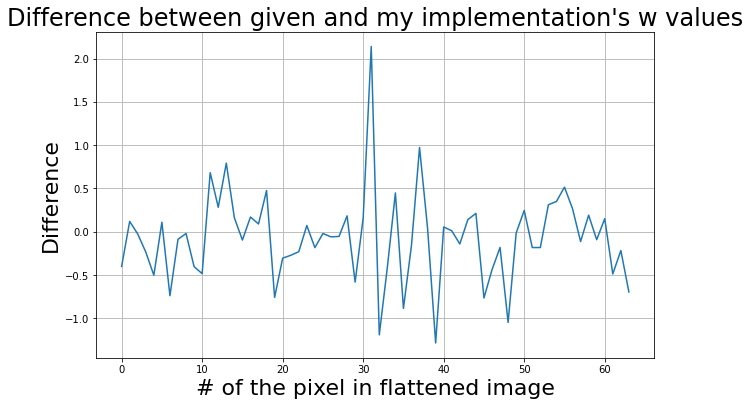

In [189]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title("Difference between given and my implementation's w values", fontsize=24)
ax.plot(np.arange(64), w_init.flatten() - w_end)
ax.set_xlabel("# of the pixel in flattened image", fontsize=22)
ax.set_ylabel("Difference", fontsize=22)


fig.tight_layout
ax.grid()
plt.show()

array([[ 150,    0],
       [   1, 1467]], dtype=int64)

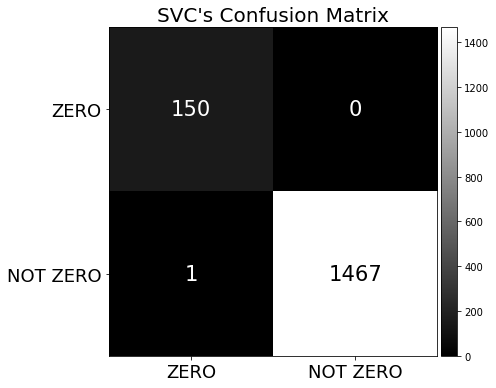

array([[ 27,   0],
       [  0, 152]], dtype=int64)

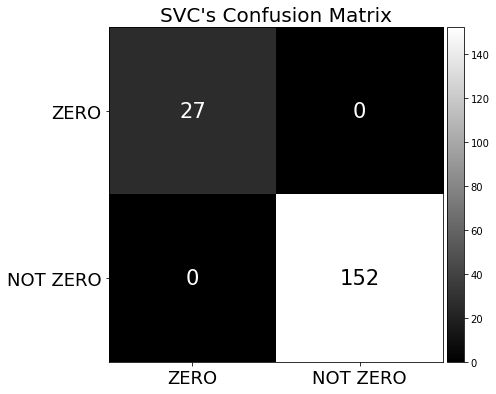

array([[ 26,   2],
       [  1, 150]], dtype=int64)

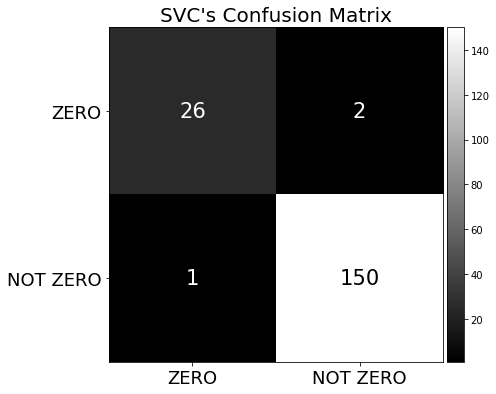

In [198]:
confusion_m_plot(y_pred0, y_train.flatten())
confusion_m_plot(y_pred, y_test.flatten())
confusion_m_plot(y_pred_test.flatten(), y_test.flatten())

### 2. MLP model in `tf.keras`

* implement a model as such:

 * 750 neuron, relu activation
 * 500 neuron, relu activation
 * 500 neuron, relu activation
 * 10 neuron, softmax activation

* use the `tf.keras.datasets.mnist` dataset in this case
* preprocess if necessary
* use the 'sgd' optimizer, log the loss ('categorical_crossentropy') and the accuracy, as well as the AUC score during training, visualize the history of these values



### 3. Evaluation

* confusion matrix on the test set
* visualize mistakes (at least 16) in a grid, show the true and the predicted labels
* plot the ROC curve for each predicted class



### 4. Come up with your own model

* come up with your own small model (< 100'000 neurons)
* train it for 50 epochs
* visualize the loss for train/test on the same plot
  * what are your thoughs on the phenomenon?
* plot the ROC curves and the AUC scores



### 5. Experiment with the CIFAR10 dataset

* preprocess the data, modify the models accordingly
  * train your small model as well as the model in the 3rd task on the CIFAR10 dataset
* compare the results
* are these models powerful enough to fit this data?




Hints:

On total you can get 10 points for fully completing all tasks.

Decorate your notebook with, questions, explanation etc, make it self contained and understandable!

Comments you code when necessary

Write functions for repetitive tasks!

Use the pandas package for data loading and handling

Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation

Use the scikit learn package for almost everything

Use for loops only if it is really necessary!

Code sharing is not allowed between student! Sharing code will result in zero points.

If you use code found on web, it is OK, but, make its source clear!
